In [1]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

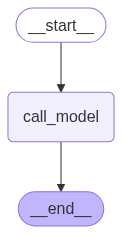

In [2]:
from langchain_community.chat_models.tongyi import ChatTongyi
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph.message import add_messages


# 定义大模型实例
llm = ChatTongyi(model="qwen-max")


# 定义状态模式
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 定义对话节点
def call_model(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": response}


# 构建状态图
builder = StateGraph(State)

# 向图中添加节点
builder.add_node("call_model", call_model)

# 构建边
builder.add_edge(START, "call_model")
builder.add_edge("call_model", END)

# 编译图
simple_graph = builder.compile()

# 可视化
display(Image(simple_graph.get_graph().draw_mermaid_png()))

In [3]:
async for chunk in simple_graph.astream(
    input={"messages": ["你好，我叫bo"]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你好，我叫bo
================================== Ai Message ==================================

你好，Bo！很高兴认识你。有什么我可以帮助你的吗？


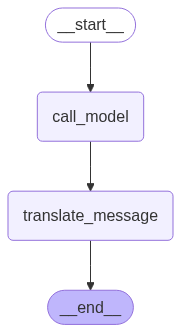

In [4]:
import os
from langchain_community.chat_models.tongyi import ChatTongyi
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# 定义大模型实例
llm = ChatTongyi(model="qwen-max")


# 定义状态模式
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 定义大模型交互节点
def call_model(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": response}


# 定义翻译节点
def translate_message(state: State):
    system_prompt = """
    Please translate the received text in any language into English as output
    """
    messages = state["messages"][-1]
    messages = [SystemMessage(content=system_prompt)] + [
        HumanMessage(content=messages.content)
    ]
    response = llm.invoke(messages)
    return {"messages": response}


# 构建状态图
builder = StateGraph(State)

# 向图中添加节点
builder.add_node("call_model", call_model)
builder.add_node("translate_message", translate_message)

# 构建边
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "translate_message")
builder.add_edge("translate_message", END)

# 编译图
simple_short_graph = builder.compile()

# 生成可视化图像结构
display(Image(simple_short_graph.get_graph().draw_mermaid_png()))

In [5]:
async for chunk in simple_short_graph.astream(
    input={"messages": ["你好，我叫木羽"]}, stream_mode="values"
):
    message = chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你好，我叫木羽
================================== Ai Message ==================================

你好，木羽！很高兴认识你。有什么我可以帮助你的吗？或者你想聊些什么？
================================== Ai Message ==================================

Hello, Mu Yu! It's nice to meet you. Is there anything I can help you with? Or is there something you'd like to chat about?


In [6]:
async for chunk in simple_short_graph.astream(
    {"messages": ["你好，我叫木羽"]}, stream_mode="debug"
):
    # print(chunk)
    print(f"Task id : {chunk['payload']['id']}")
    if chunk["type"] == "task":
        for message in chunk["payload"]["input"]["messages"]:
            print(f"Message id:{message.id}, Message content:{message.content}")

    if chunk["type"] == "task_result":
        print(
            f"Message id:{chunk['payload']['result'][0][1].id}, Message content:{chunk['payload']['result'][0][1].content}"
        )  # tuple 类型

    print("------------------------------------------------")
    print("------------------------------------------------")

Task id : be27038b-1daf-6042-7c46-1206ab2483e3
Message id:faa29039-330d-4a46-a433-aa97df783234, Message content:你好，我叫木羽
------------------------------------------------
------------------------------------------------
Task id : be27038b-1daf-6042-7c46-1206ab2483e3
Message id:run--f4bec3ed-cd89-4866-b3f1-af54b1c8d31a-0, Message content:你好，木羽！很高兴认识你。有什么我可以帮助你的吗？
------------------------------------------------
------------------------------------------------
Task id : 0511eeb8-406e-0c9f-868b-0d64c2ed5ddd
Message id:faa29039-330d-4a46-a433-aa97df783234, Message content:你好，我叫木羽
Message id:run--f4bec3ed-cd89-4866-b3f1-af54b1c8d31a-0, Message content:你好，木羽！很高兴认识你。有什么我可以帮助你的吗？
------------------------------------------------
------------------------------------------------
Task id : 0511eeb8-406e-0c9f-868b-0d64c2ed5ddd
Message id:run--7b27eb39-346e-46c2-8483-721358ead69b-0, Message content:Hello, Mu Yu! Nice to meet you. Is there anything I can help you with?
---------------------------------

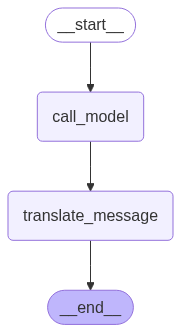

In [8]:
# MemorySaver

from langchain_community.chat_models.tongyi import ChatTongyi
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver


# 定义大模型实例
llm = ChatTongyi(model="qwen-plus")


# 定义状态模式
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 定义大模型交互节点
def call_model(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": response}


# 定义翻译节点
def translate_message(state: State):
    system_prompt = """
    Please translate the received text in any language into English as output
    """
    messages = state["messages"][-1]
    messages = [SystemMessage(content=system_prompt)] + [
        HumanMessage(content=messages.content)
    ]
    response = llm.invoke(messages)
    return {"messages": response}


# 构建状态图
builder = StateGraph(State)

# 向图中添加节点
builder.add_node("call_model", call_model)
builder.add_node("translate_message", translate_message)

# 构建边
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "translate_message")
builder.add_edge("translate_message", END)

memory = MemorySaver()

# 编译图
graph_with_memory = builder.compile(checkpointer=memory)

# 生成可视化图像结构
display(Image(simple_short_graph.get_graph().draw_mermaid_png()))

In [9]:
config = {"configurable": {"thread_id": "1"}}

async for chunk in graph_with_memory.astream(
    input={"messages": ["你好，我叫木羽"]}, stream_mode="values", config=config
):
    message = chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你好，我叫木羽
================================== Ai Message ==================================

你好，木羽！有什么我可以帮你的吗？😊
================================== Ai Message ==================================

Hello, Muchi! Is there anything I can assist you with? 😊


In [10]:
config = {"configurable": {"thread_id": "1"}}

async for chunk in graph_with_memory.astream(
    input={"messages": ["我叫什么？"]}, stream_mode="values", config=config
):
    message = chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我叫什么？
================================== Ai Message ==================================

你叫木羽。😊

You're called Muchi. 😊
================================== Ai Message ==================================

Your translation is already in English! However, there seems to be a small inconsistency. If the original name is "木羽", the Romanization should be "Muyu" rather than "Muchi". Here's the corrected version:

**You're called Muyu. 😊**


In [ ]:
# SqliteSaver

from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [14]:
checkpoint_data = {
    "thread_id": "muyu123",
    "thread_ts": "2024-10-30T07:23:38.656547+00:00",
    "checkpoint": {
        "id": "1ef968fe-1eb4-6049-bfff",
    },
    "metadata": {"timestamp": "2024-10-30T07:23:38.656547+00:00"},
}

with SqliteSaver.from_conn_string(":memory:") as memory:
    saved_config = memory.put(
        config={
            "configurable": {
                "thread_id": checkpoint_data["thread_id"],
                "thread_ts": checkpoint_data["thread_ts"],
                "checkpoint_ns": "",
            }
        },
        checkpoint=checkpoint_data["checkpoint"],
        metadata=checkpoint_data["metadata"],
        new_versions={"writes": {"key": "value"}},
    )

In [15]:
saved_config

{'configurable': {'thread_id': 'muyu123',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef968fe-1eb4-6049-bfff'}}

In [16]:
with SqliteSaver.from_conn_string(":memory:") as memory:
    saved_config = memory.put(
        config={
            "configurable": {
                "thread_id": checkpoint_data["thread_id"],
                "thread_ts": checkpoint_data["thread_ts"],
                "checkpoint_ns": "",
            }
        },
        checkpoint=checkpoint_data["checkpoint"],
        metadata=checkpoint_data["metadata"],
        new_versions={"writes": {"key": "value"}},
    )

    config = {"configurable": {"thread_id": checkpoint_data["thread_id"]}}

    checkpoints = list(memory.list(config))
    for checkpoint in checkpoints:
        print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'muyu123', 'checkpoint_ns': '', 'checkpoint_id': '1ef968fe-1eb4-6049-bfff'}}, checkpoint={'id': '1ef968fe-1eb4-6049-bfff'}, metadata={'timestamp': '2024-10-30T07:23:38.656547+00:00'}, parent_config=None, pending_writes=[])


In [17]:
from langchain_core.tools import tool
from pydantic import BaseModel, Field
import requests
import json


class WeatherLoc(BaseModel):
    location: str = Field(description="The location name of the city")


@tool(args_schema=WeatherLoc)
def get_weather(location):
    """
    Function to query current weather.
    :param loc: Required parameter, of type string, representing the specific city name for the weather query. \
    Note that for cities in China, the corresponding English city name should be used. For example, to query the weather for Beijing, \
    the loc parameter should be input as 'Beijing'.
    :return: The result of the OpenWeather API query for current weather, with the specific URL request address being: https://api.openweathermap.org/data/2.5/weather. \
    The return type is a JSON-formatted object after parsing, represented as a string, containing all important weather information.
    """
    # Step 1.构建请求
    url = "https://api.openweathermap.org/data/2.5/weather"

    # Step 2.设置查询参数
    params = {
        "q": location,
        "appid": os.environ["OPENWEATHER_API_KEY"],  # 输入API key
        "units": "metric",  # 使用摄氏度而不是华氏度
        "lang": "zh_cn",  # 输出语言为简体中文
    }

    # Step 3.发送GET请求
    response = requests.get(url, params=params)

    # Step 4.解析响应
    data = response.json()
    return json.dumps(data)

In [19]:
from langgraph.prebuilt import create_react_agent

with SqliteSaver.from_conn_string(":memory:") as checkpointer:
    graph = create_react_agent(llm, tools=[get_weather], checkpointer=checkpointer)

    config = {"configurable": {"thread_id": "1"}}

    for chunk in graph.stream(
        {"messages": ["你好，我叫 bo"]}, config, stream_mode="values"
    ):
        chunk["messages"][-1].pretty_print()

    for chunk in graph.stream(
        {"messages": ["请问我叫什么？"]}, config, stream_mode="values"
    ):
        chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你好，我叫 bo
================================== Ai Message ==================================

你好，bo！有什么可以帮助你的吗？
================================ Human Message =================================

请问我叫什么？
================================== Ai Message ==================================

你叫 bo。


In [20]:
from langgraph.prebuilt import create_react_agent
import sqlite3

conn = sqlite3.connect(":memory:", check_same_thread=False)
checkpointer = SqliteSaver(conn)
graph = create_react_agent(llm, tools=[get_weather], checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}}

for chunk in graph.stream(
    {"messages": ["你好，我叫 bo"]}, config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

for chunk in graph.stream(
    {"messages": ["请问我叫什么？"]}, config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你好，我叫 bo
================================== Ai Message ==================================

你好，bo！有什么我可以帮你的吗？
================================ Human Message =================================

请问我叫什么？
================================== Ai Message ==================================

你叫 bo。


## 长期记忆

In [21]:
import uuid
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

namespace_for_memory = ("1", "memories")

memory_id = str(uuid.uuid4())
memory = {"user": "你好，我叫bo"}

in_memory_store.put(namespace_for_memory, memory_id, memory)

In [22]:
in_memory_store.search(namespace_for_memory)

[Item(namespace=['1', 'memories'], key='76b03ca4-d2a0-4532-ace7-21ed8940099a', value={'user': '你好，我叫bo'}, created_at='2025-07-29T11:26:35.092960+00:00', updated_at='2025-07-29T11:26:35.092960+00:00', score=None)]

In [25]:
in_memory_store.search(("1",))

[Item(namespace=['1', 'memories'], key='76b03ca4-d2a0-4532-ace7-21ed8940099a', value={'user': '你好，我叫bo'}, created_at='2025-07-29T11:26:35.092960+00:00', updated_at='2025-07-29T11:26:35.092960+00:00', score=None)]

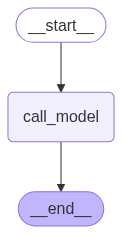

In [30]:
from langchain_community.chat_models.tongyi import ChatTongyi
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.runnables import RunnableConfig
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore


in_memory_store = InMemoryStore()
memory = MemorySaver()

# 定义大模型实例
llm = ChatTongyi(model="qwen-plus")


# 定义状态模式
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 定义对话节点， 访问记忆并在模型调用中使用它们。
def call_model(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    # 获取用户id
    user_id = config["configurable"]["user_id"]

    # 定义命名空间
    namespace = ("memories", user_id)

    # 根据用户id检索记忆
    memories = store.search(namespace)
    info = "\n".join([d.value["data"] for d in memories])

    # # 存储记忆
    last_message = state["messages"][-1]
    store.put(namespace, str(uuid.uuid4()), {"data": last_message.content})

    system_msg = f"Answer the user's question in context: {info}"

    response = llm.invoke(
        [{"type": "system", "content": system_msg}] + state["messages"]
    )

    # 存储记忆
    store.put(namespace, str(uuid.uuid4()), {"data": response.content})
    return {"messages": response}


# 构建状态图
builder = StateGraph(State)

# 向图中添加节点
builder.add_node("call_model", call_model)

# 构建边
builder.add_edge(START, "call_model")
builder.add_edge("call_model", END)

# 编译图
graph = builder.compile(checkpointer=memory, store=in_memory_store)

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
config = {"configurable": {"thread_id": "10"}, "user_id": "6"}

async for chunk in graph.astream(
    {"messages": ["你好，我是木羽"]}, config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你好，我是木羽
================================== Ai Message ==================================

你好，木羽！有什么我可以帮你的吗？😊


In [32]:
config = {"configurable": {"thread_id": "10"}, "user_id": "6"}

async for chunk in graph.astream(
    {"messages": ["我叫什么？"]}, config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我叫什么？
================================== Ai Message ==================================

你叫木羽呀！👋 我们刚刚才认识呢～有什么问题或者需要帮助的吗？


In [33]:
config = {"configurable": {"thread_id": "20"}, "user_id": "6"}

async for chunk in graph.astream(
    {"messages": ["我叫什么？"]}, config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我叫什么？
================================== Ai Message ==================================

你叫木羽呀！✨ 我们之前已经聊过啦～ 有什么需要我帮忙的吗？😊


In [34]:
config = {"configurable": {"thread_id": "30"}, "user_id": "8"}

async for chunk in graph.astream(
    {"messages": ["我叫什么？"]}, config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我叫什么？
================================== Ai Message ==================================

您没有告诉我您的名字，所以我无法回答这个问题。如果您愿意分享，我可以帮助您记录或处理与您的名字相关的信息。
